# Example 6.17

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.linalg as la
from collections import namedtuple
from IPython.display import display, Math
from itertools import combinations
from scipy import stats

In [2]:
def load_data() -> pd.DataFrame:
    df = pd.read_excel(r'..\..\Data\Table6.7.xlsx')
    df['lnMass'] = np.log(df.Mass)
    df['lnSVL'] = np.log(df.SVL)
    df['Genera'] = df.Genera.map({0: 'C', 1: 'S'})
    return df #[['Genera','lnMass','lnSVL']]

In [3]:
svl_df = load_data()
svl_df.head(3)

,Mass,SVL,Genera,lnMass,lnSVL
0,7.513,74.0,C,2.016635,4.304065
1,5.032,69.5,C,1.615818,4.241327
2,5.867,72.0,C,1.769343,4.276666


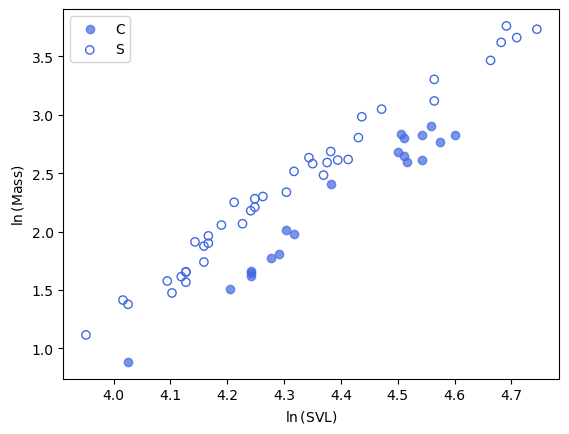

In [4]:
plt.scatter(svl_df[svl_df.Genera.eq('C')].lnSVL, svl_df[svl_df.Genera.eq('C')].lnMass, marker='o', facecolor='royalblue', edgecolor='royalblue', alpha=0.7, label='C')
plt.scatter(svl_df[svl_df.Genera.eq('S')].lnSVL, svl_df[svl_df.Genera.eq('S')].lnMass, marker='o', facecolor='none', edgecolor='royalblue', label='S')
plt.xlabel(r'$\ln\left(\text{SVL}\right)$')
plt.ylabel(r'$\ln\left(\text{Mass}\right)$')
plt.legend()
plt.show()

**Note:** The univariate "large sample" intervals printed in the book look weird to me. They're very close to 95% Welch's t-intervals, when the degrees of freedom (df) are the same as the Student's t-interval. That is, of $n_{1} + n_{2} - 2$, which isn't correct. The only situation where Welch's t df is equal to the Student's t df is when the sample sizes of both groups are the same ($n_{1} = n_{2}$), and the (scalar) variance values for both groups is the same ($S_{1}^{2} = S_{2}^{2}$). We know that group C has $n_{1} = 20$ observations and group S has $n_{2} = 40$, so it's not going to work ($n_{1} \ne n_{2}$).

When group sizes are different, $n_{1} \ne n_{2}$, Welch's t-interval has degrees of freedom are $\frac{ {( S_{1} / n_{1} + S_{2} / n_{2} )}^{2} }{\frac{ {(S_{1} / n_{1})}^{2} }{n_{1} - 1} + \frac{ {(S_{2} / n_{2})}^{2} }{n_{2} - 1} }$. Welch's t can handle differing group sample sizes and unequal group variances. In the article Why Psychologists Should by Default Use Welch’s t-test Instead of Student’s t-test, by Marie Delacre, Daniël Lakens and Christophe Leys, they argue it's better overall test to use.

Since the book mentions "large sample", below I compute Welch's t, where the t is replaced with a standard normal. I also compute the incorrect Wech's t intervals, just to show that they're close to what's printed in the book.

In [5]:
GroupData = namedtuple('GroupData', ['n','p','X','xbar','S'])

In [6]:
data_cols = ['lnMass','lnSVL']

svl_data = {grp: GroupData(n=data[data_cols].shape[0],
                           p=data[data_cols].shape[1],
                           X=data,
                           xbar=data[data_cols].mean().to_numpy()[:, np.newaxis],
                           S=data[data_cols].cov(ddof=1).to_numpy()
                           ) for grp, data in svl_df.groupby('Genera')}

In [7]:
alpha = 0.05
a1 = np.array([[1],[0]])  # Vector to compute CI for ln(Mass).
a2 = np.array([[0],[1]])  # Vector to compute CI for ln(SVL).

### Compute large sample 95% Student's t CI

In [8]:
def student_t_ci(data: dict[str, GroupData], a: np.ndarray, alpha: float, large_sample: bool):
    # Assume equal variance!
    n1, n2 = [d.n for d in data.values()]
    mean_diff = [x - y for x, y in combinations([d.xbar for d in data.values()], 2)][0]
    SE = np.sqrt((1/(n1 + n2 - 2)) * (1/n1 + 1/n2) * a.T @ sum([(d.n - 1)*d.S for d in data.values()]) @ a)
    test_stat = (a.T @ mean_diff) / SE

    if large_sample:
        ci = a.T @ mean_diff + np.array([-1,1]) * stats.norm.ppf(1-alpha/2) * SE
        p = 2 * stats.norm.sf(abs(test_stat)).item()
    else:
        df = n1 + n2 - 2
        ci = a.T @ mean_diff + np.array([-1,1]) * stats.t.ppf(1-alpha/2,df=df) * SE
        p = 2 * stats.t.sf(abs(test_stat), df).item()

    return {'CI': ci, 'P-value': p}


In [9]:
student_ln_mass_ci = student_t_ci(svl_data, a1, alpha, large_sample=True)

In [10]:
display(Math(r'\ln(\text{Mass}): \textbf{a}_{1}^{\prime} {(\bar{\textbf{x}}_{1} - \bar{\textbf{x}}_{2})}'
             r'\pm '
             r'z(\alpha/2)'
             # r'\sqrt{ \textbf{a}_{1}^{\prime} \left( \frac{\textbf{S}_{1}}{n_{1}} + \frac{\textbf{S}_{2}}{n_{2}} \right) \textbf{a}_{1} }'
             r'\sqrt{ \textbf{a}_{1}^{\prime} \textbf{S}_{\text{pooled}} \textbf{a}_{1} \left( \frac{1}{n_{1}} + \frac{1}{n_{2}} \right) }'
             '='
             f'({student_ln_mass_ci.get('CI')[0,0]:.3f}, {student_ln_mass_ci.get('CI')[0,1]:.3f})'
             fr'\hspace{{0.4cm}}\text{{and}}\hspace{{0.4cm}}\text{{ P-value: }}{student_ln_mass_ci.get('P-value'):.2f}'
             ))

<IPython.core.display.Math object>

$\ln(\text{Mass})$ 95% Student t interval for large sample. Assumes equal variance. A bit different than what's in the book.

### Compute large sample 95% Welch's CI

In [11]:
def welch_t_ci(data: dict[str, GroupData], a: np.ndarray, alpha: float, large_sample: bool):
    # Could have equal variance or not.
    mean_diff = [x - y for x, y in combinations([d.xbar for d in data.values()], 2)][0]
    SE = np.sqrt(a.T @ sum([d.S/d.n for d in data.values()]) @ a)
    test_stat = (a.T @ mean_diff) / SE

    if large_sample:
        ci = a.T @ mean_diff + np.array([-1,1]) * stats.norm.ppf(1-alpha/2) * SE
        p = 2 * stats.norm.sf(abs(test_stat)).item()
    else:
        df_num = sum([(a.T @ d.S @ a) /d.n for d in data.values()])**2
        df_denom = sum([np.power((a.T @ d.S @ a)/d.n,2)/(d.n-1) for d in data.values()])
        df = df_num/df_denom
        
        ci = a.T @ mean_diff + np.array([-1,1]) * stats.t.ppf(1-alpha/2,df=df) * SE
        p = 2 * stats.t.sf(abs(test_stat), df).item()
    return {'CI': ci, 'P-value': p}

In [12]:
ln_mass_ci = welch_t_ci(svl_data, a1, alpha, large_sample=True)

In [13]:
display(Math(r'\ln(\text{Mass}): \textbf{a}_{1}^{\prime} {(\bar{\textbf{x}}_{1} - \bar{\textbf{x}}_{2})}'
             r'\pm '
             r'z(\alpha/2)'
             r'\sqrt{ \textbf{a}_{1}^{\prime} \left( \frac{\textbf{S}_{1}}{n_{1}} + \frac{\textbf{S}_{2}}{n_{2}} \right) \textbf{a}_{1} }'
             '='
             f'({ln_mass_ci.get('CI')[0,0]:.3f}, {ln_mass_ci.get('CI')[0,1]:.3f})'
             fr'\hspace{{0.4cm}}\text{{and}}\hspace{{0.4cm}}\text{{ P-value: }}{ln_mass_ci.get('P-value'):.2f}'
             ))

<IPython.core.display.Math object>

In [ ]:
ln_svl_ci = welch_t_ci(svl_data, a2, alpha, large_sample=True)

In [15]:
display(Math(r'\ln(\text{SVL}): \textbf{a}_{2}^{\prime} {(\bar{\textbf{x}}_{1} - \bar{\textbf{x}}_{2})}'
             r'\pm '
             r'z(\alpha/2)'
             r'\sqrt{ \textbf{a}_{2}^{\prime} \left( \frac{\textbf{S}_{1}}{n_{1}} + \frac{\textbf{S}_{2}}{n_{2}} \right) \textbf{a}_{2} }'
             '='
             f'({ln_svl_ci.get('CI')[0,0]:.3f}, {ln_svl_ci.get('CI')[0,1]:.3f})'
             fr'\hspace{{0.4cm}}\text{{and}}\hspace{{0.4cm}}\text{{ P-value: }}{ln_svl_ci.get('P-value'):.2f}'
             ))

<IPython.core.display.Math object>

In [16]:
# Welch's t-interval for ln(Mass) wrong df! Close to values in the book.
SE = np.sqrt(a1.T @ sum([d.S/d.n for d in svl_data.values()]) @ a1)
a1.T @ (svl_data.get('C').xbar - svl_data.get('S').xbar) + np.array([-1,1]) * stats.t.ppf(1-(0.05/2),df=20+40-2) * SE

array([[-0.47679409,  0.22035042]])

In [17]:
# Welch's t-interval for ln(Mass) wrong df! Close to values in the book.
SE = np.sqrt(a2.T @ sum([d.S/d.n for d in svl_data.values()]) @ a2)
a2.T @ (svl_data.get('C').xbar - svl_data.get('S').xbar) + np.array([-1,1]) * stats.t.ppf(1-(0.05/2),df=20+40-2) * SE

array([[-0.01093867,  0.18360932]])

### Compute $T^{2}$ and large sample p-value

In [18]:
def my_T2(data: dict[str, GroupData], a: np.ndarray, alpha: float, large_sample: bool):
    # Assuming equal variance here.
    S_pooled_denom = sum([(d.n - 1) for d in data.values()]) # Compute (n_{1} - 1) + ... + (n_{\ell} - 1)
    mean_diff = [x - y for x, y in combinations([d.xbar for d in data.values()], 2)][0]
    S_pooled = (1/S_pooled_denom) * sum([(d.n - 1)*d.S for d in data.values()])
    
    cov_const = sum([1/d.n for d in data.values()])  # Compute (1/n_{1}) + ... + (1/n_{\ell})
    T2 = (mean_diff.T @ la.inv(cov_const * S_pooled) @ mean_diff).item()

    n = sum([d.n for d in data.values()])
    col_counts = set([d.X.shape[1] for d in data.values()])
    assert len(col_counts) == 1, "Differing number of columns between datasets!"
    p = col_counts.pop()

    if large_sample:
        crit_value = stats.chi2.ppf(1-alpha, df=p)
        p_value = 2 * stats.chi2.sf(abs(T2), df=p).item()
    else:
        crit_value = stats.f.ppf(1-alpha, dfn=p, dfd=n-(p+1))
        p_value = 2 * stats.f.sf(abs(T2), dfn=p, dfd=n-(p+1)).item()

    return T2 , crit_value, p_value

In [19]:
T2, _, T2_p_value = my_T2(svl_data, a1, alpha, large_sample=True)

In [20]:
display(Math(r'T^{2}'
             '='
             r'{[\bar{\textbf{X}}_{1} - \bar{\textbf{X}}_{2} - (\bm{\mu_{1}} - \bm{\mu_{2}})]}^{\prime}'
             r'{\left[ \left( \frac{1}{n_{1}} + \frac{1}{n_{2}} \right) \textbf{S}_{\text{pooled}} \right]}^{-1}'
             r'[\bar{\textbf{X}}_{1} - \bar{\textbf{X}}_{2} - (\bm{\mu_{1}} - \bm{\mu_{2}})]'
             '='
             f'{T2:.2f}'
             fr'\hspace{{0.4cm}}\text{{and}}\hspace{{0.4cm}}\text{{ P-value: }}{T2_p_value:.2f}'
             ))

<IPython.core.display.Math object>